<a href="https://colab.research.google.com/github/hannape/CNN-pierwsze-podejscie/blob/master/cnn_ES_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(60, 87)
1
(1, 60, 87)
(24464, 1, 60, 87) (24464,)
(10793, 1, 60, 87) (10793,)


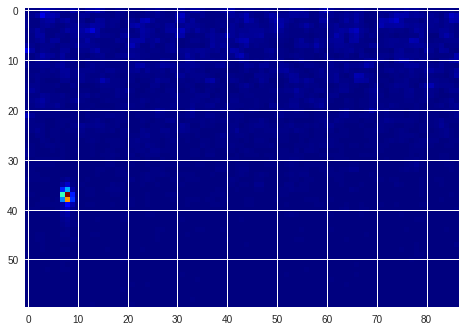

In [56]:
# previous version, with hidden code and comments - cnn_scorer_not_working
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.utils import class_weight
from sklearn.metrics import  make_scorer
from sklearn.metrics import log_loss
K.set_image_dim_ordering('th')
import numpy as np
from sklearn import preprocessing
import glob
import os
import random
import functools
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from numpy.random import seed
seed(667)
from tensorflow import set_random_seed
set_random_seed(667)
import random
random.seed()

X_train = numpy.load('drive/My Drive/X_train.npy')
y_train = numpy.load('drive/My Drive/y_train.npy')
X_test = numpy.load('drive/My Drive/X_test.npy')
y_test = numpy.load('drive/My Drive/y_test.npy')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=667)
plt.imshow(X_val[2], cmap="jet")
print(np.shape(X_val[2]))


X_train = X_train.reshape(X_train.shape[0], 1, 60, 87).astype('float32')
X_val = X_val.reshape(X_val.shape[0], 1, 60, 87).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 60, 87).astype('float32')

#plt.imshow(X_val[67], cmap="jet")
print(y_val[2])
print(np.shape(X_val[2]))
input_shape = (1, 60, 87)
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


In [0]:
c_w = { 0:0.02, 1:0.98}
index = ['r%d' % x for x in range(len(y_train))]
a = [c_w[class_label] for class_label in y_train]
sample_weight_frame = pd.DataFrame(a, index = index)
score_params = {"sample_weight": sample_weight_frame}
#print(sample_weight_frame[0:5])


In [0]:
# https://github.com/keras-team/keras/issues/2115

### SCORERS
import tensorflow as tf
import functools
from functools import partial, update_wrapper

def my_score(y_true, y_pred, sample_weight): 
  return log_loss(y_true.values, y_pred, sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1), normalize=True)

def wrapped_partial(func, *args, **kwargs):
	partial_func = partial(func, *args, **kwargs)
	update_wrapper(partial_func, func)
	return partial_func

def binary_crossentropy_weigted(y_true, y_pred, class_weights):
	y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
	loss = K.mean(class_weights*(-y_true * K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred)),axis=-1)
	return loss

my_scorer = make_scorer(my_score,greater_is_better=False, needs_threshold=False,**score_params)  ## scoring for gridsearchCV
custom_loss = wrapped_partial(binary_crossentropy_weigted, class_weights=np.array([0.02, 0.98])) ## scoring for model.compile


## AUC METRIC
def as_keras_metric(method):
    import functools
    from keras import backend as K
    
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
  
auc_roc = as_keras_metric(tf.metrics.auc)


**BUILDING THE MODEL**

In [0]:
def make_model_modified(): #(dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out):
  
    dense_layer_sizes=128
    filters=10
    kernel_size=(3,3)
    pool_size= (2,2) 
    lr=0.0001 
    drop_out = 0.5
        
    model = Sequential()
    model.add(Conv2D(filters, kernel_size,input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
   
    model.add(Flatten())
    model.add(Dense(dense_layer_sizes, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=custom_loss,#'binary_crossentropy',#loss_2_args(y_true, y_pred)'',#loss='binary_crossentropy'
                  # co tu powinno wejść? o samo co do scoring w GridSearchCv? chyba nie: https://stackoverflow.com/questions/40572743/scikit-learn-grid-search-own-scoring-object-syntax
                  # my_score2(sample_weight = sample_weight_frame), <------------------- nie umiem zrobić by działał tutaj. Która funkcja? my_score czy my_scorer ?
                  # my_score2(sample_weight_frame) ---->  https://stackoverflow.com/questions/46858016/keras-custom-loss-function-to-pass-arguments-other-than-y-true-and-y-pred
                  # my_loss ---------------------------->też nie chodzi a chyba powinien, coś z formatem nie tak.  ERROR: 'Tensor' object has no attribute 'values'
                  # inne źródło: https://github.com/keras-team/keras/issues/2115
                  optimizer=keras.optimizers.Adam(lr),#'adam',
                  metrics=['accuracy',auc_roc])

    return model

**GRID SEARCH** // none here



In [0]:
#@title
my_classifier = KerasClassifier(make_model_modified)
validator = GridSearchCV(my_classifier,
                         param_grid={'dense_layer_sizes': [128],
                                     # epochs is avail for tuning even when not
                                     # an argument to model building function
                                     'epochs': [100], #[10,20,30],
                                     'filters': [10],
                                     'kernel_size': [(3,3)],
                                     'pool_size': [(2,2)],
                                     # 'class_weight': [{ 0:0.02, 1:0.98}],  <------------------------------- może w ten sposób? Ale t też tylko w grid searchu
                                     'batch_size': [32], 
                                     'drop_out':[0.5],#[0.2,0.5],
                                     'lr': [0.001]}, #[0.01,0.001,0.0001]},
                         scoring=my_scorer, n_jobs=1, refit=True, cv = 3)  ## SCORING ZMIENIONY na my_scorer (inne, np: 'roc_auc')

##https://stackoverflow.com/questions/49581104/sklearn-gridsearchcv-not-using-sample-weight-in-score-function

**CALLBACKS**

In [0]:
#@title
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.losses_val = []
        self.auc = []
        self.auc_val = []
        self.acc = []
        self.acc_val = []
        
        self.fig = plt.figure()        
        self.logs = []
        
        
    def on_epoch_begin(self, epoch, logs={}):
		    clear_output(wait=True);

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))
        self.auc.append(logs.get('auc'))
        self.i += 1
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.losses_val, label="val_loss")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.auc, label="auc")
        #plt.plot(self.x, self.auc_val, label="val_auc")
        plt.legend()
        
        #plt.subplot(1, 3, 3)  # nie działa :()
        #plt.plot(self.x, self.acc, label="acc")
        #plt.plot(self.x, self.acc_val, label="val_acc")
        #plt.legend()
        
        plt.show()
      
        
plot_losses = PlotLosses()

class Histories(keras.callbacks.Callback):
	def on_train_begin(self, logs={}):
		self.aucs = []
		self.losses = []

	def on_train_end(self, logs={}):
		return

	def on_epoch_begin(self, epoch, logs={}):
		return

	def on_epoch_end(self, epoch, logs={}):
		self.losses.append(logs.get('loss'))
		y_pred = self.model.predict(self.validation_data[0])
		self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
		a = (roc_auc_score(self.validation_data[1], y_pred))
		#print(" AUC_on_val: %f " % a)
		return

	def on_batch_begin(self, batch, logs={}):
		return

	def on_batch_end(self, batch, logs={}):    return
  
histories = Histories()

 - 12s - loss: 0.0186 - acc: 0.9924 - auc: 0.7497 - val_loss: 0.0311 - val_acc: 0.9887 - val_auc: 0.7509


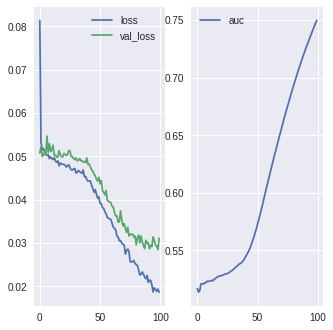

dict_keys(['val_loss', 'val_acc', 'val_auc', 'loss', 'acc', 'auc'])


In [130]:
# dense_layer_sizes,filters, kernel_size,pool_size,lr, drop_out)
#my_classifier2 = KerasClassifier(make_model_modified(128,10,(3,3),(2,2),0.001,0.5))
my_model = make_model_modified()

############
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler, CSVLogger
import math

#def step_decay(epoch):
#	initial_lrate = 0.0001
#	drop = 0.1
#	epochs_drop = 30.0
#	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#	#print(lrate)
#	return lrate

keras.callbacks.CSVLogger('', separator=',', append=False)

#lrate = LearningRateScheduler(step_decay)
csv_logger = CSVLogger('drive/My Drive/przebiegi/training_200e_0001_adam_filt20.log')
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=30, mode='max', baseline=None, restore_best_weights=True)


y_frame = pd.DataFrame(y_train, index=index)
grid_result = my_model.fit(X_train, y_frame, batch_size = 32, callbacks=[plot_losses, csv_logger, histories], epochs=100,validation_data=(X_val, y_val), verbose = 2) #, class_weight = c_w)
# [es, plot_losses, lrate, csv_logger, histories]
c = grid_result.history.keys()
print(grid_result.history.keys())
#grid_result = validator.fit(X_train, y_frame, callbacks=[es, plot_losses]) #, class_weight = c_w)

############


In [94]:
c = grid_result.history.keys()
print(grid_result.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_auc', 'loss', 'acc', 'auc', 'lr'])


CNN Error for val set: 1.13%
CNN Error for test set: 4.21%
AUC: 0.736


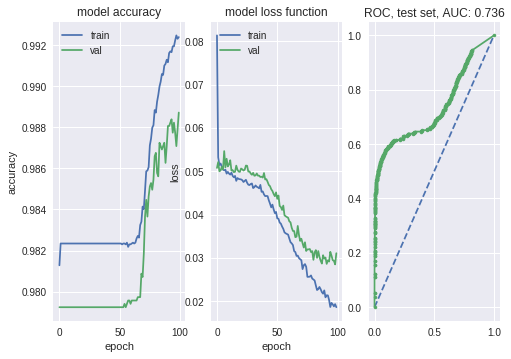

In [131]:
model = my_model
hist = grid_result
# Final evaluation of the model
scores_val = model.evaluate(X_val, y_val, verbose=0)
print("CNN Error for val set: %.2f%%" % (100-scores_val[1]*100))
scores_test = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error for test set: %.2f%%" % (100-scores_test[1]*100))

# summarize history for accuracy
plt.subplot(1, 3, 1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.subplot(1, 3, 2)

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.show()

# calculate AUC of final model on a test set
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
plt.subplot(1, 3, 3)
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC, test set, AUC: %.3f' % auc)
pyplot.show()

In [0]:
#@title
# calculate AUC of final model on a test set
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()

with open('drive/My Drive/ES_200e.txt', 'w') as f:
  print('Filename:', validator.best_params_, file=f)
  print('AUC on test set: %.3f' % auc)
  
from sklearn.externals import joblib
joblib.dump(grid_result.best_estimator_, 'model_200e.pkl')

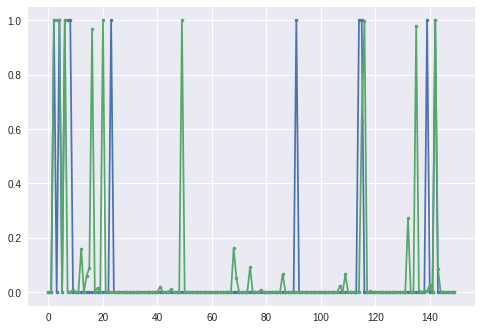

In [108]:
pyplot.plot(y_test2[8450:8600], marker='.')
pyplot.plot(probs[8450:8600], marker='.')


In [0]:
#@title
print('The parameters of the best model are: ')
print(validator.best_params_)

best_model = validator.best_estimator_.model
metric_names = best_model.metrics_names
metric_values = best_model.evaluate(X_test, y_test)
for metric, value in zip(metric_names, metric_values):
  print(metric, ': ', value)
  
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
  
# calculate AUC of final model on a test set
probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]
y_test2 = numpy.load('drive/My Drive/y_test.npy')  # osobno, bo inny wymiar

auc = roc_auc_score(y_test2, probs)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test2, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
plt.title('ROC curve for test set')
pyplot.show()

with open('drive/My Drive/ES_200e.txt', 'w') as f:
  print('Filename:', validator.best_params_, file=f)
  print('AUC on test set: %.3f' % auc)
  
from sklearn.externals import joblib
joblib.dump(grid_result.best_estimator_, 'model_200e.pkl')
